# Real Vs Fake Face Detection

#### We have seen after the development of GANs, Deepfakes came into existence.Though the development of these techniques were primarily to increase the amount of training data but many people were found misusing these techniques for criminal activities. So, it is the need of the hour to develop one such model which can differentiate between real and deepfake faces.

## Import Dataset and Necessary Libraries

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/realVSfake.zip"
!unzip -o realVSfake.zip 
!rm realVSfake.zip

In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [2]:
print(os.listdir("realVSfake/real_and_fake_face"))

['training_fake', 'training_real']


In [3]:
real = "realVSfake/real_and_fake_face/training_real/"
fake = "realVSfake/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

## Visulaizing the real and fake faces

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

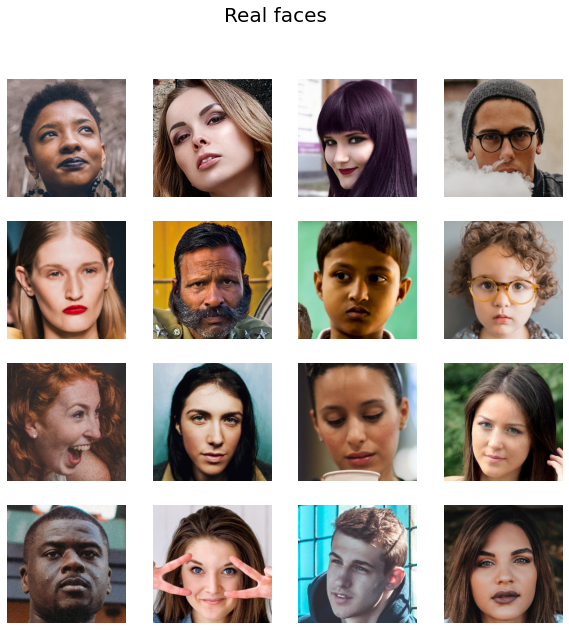

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

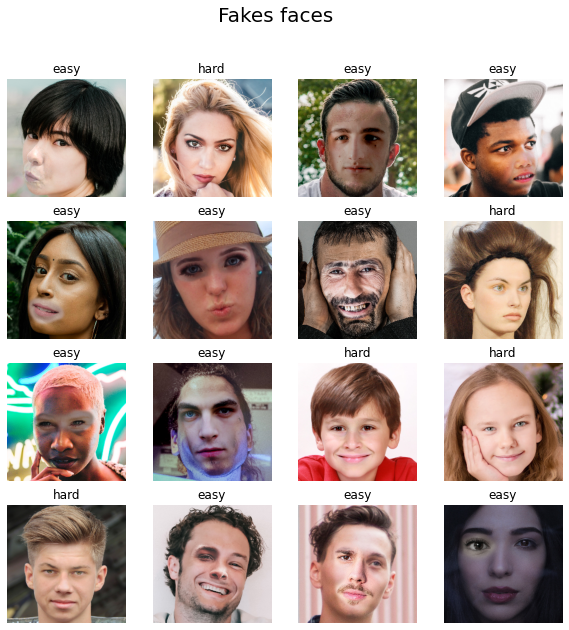

In [6]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [7]:
dataset_path = "realVSfake/real_and_fake_face"

## Data augumentation and Data Loader

In [8]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [9]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 166 images belonging to 2 classes.


In [10]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=32)

Found 832 images belonging to 2 classes.


## Building VGG16 model from Scratch

In [12]:
# The original model does not contain Dropout Layers
vgg_model = Sequential()
vgg_model.add(Conv2D(filters=64, kernel_size=1, input_shape=(224, 224, 3), activation='relu'))
vgg_model.add(Conv2D(filters=64, kernel_size=1, activation='relu'))
vgg_model.add(MaxPooling2D(pool_size=2))
vgg_model.add(Dropout(0.2))

vgg_model.add(Conv2D(filters=128, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=128, kernel_size=1, activation='relu'))
vgg_model.add(MaxPooling2D(pool_size=2))
vgg_model.add(Dropout(0.2))

vgg_model.add(Conv2D(filters=256, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=256, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=256, kernel_size=1, activation='relu'))
vgg_model.add(MaxPooling2D(pool_size=2))
vgg_model.add(Dropout(0.2))

vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(MaxPooling2D(pool_size=2))
vgg_model.add(Dropout(0.2))

vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
vgg_model.add(MaxPooling2D(pool_size=2))
vgg_model.add(Dropout(0.2))

vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(2, activation='softmax'))

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     8320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     16512     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

## Model Training

In [25]:
vgg_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")
history = vgg_model.fit(train,
                    epochs=10                        
                    )

Epoch 1/10
26/26 [==============================] - 104s 4s/step - loss: 0.6838 - accuracy: 0.5769
Epoch 2/10
26/26 [==============================] - 104s 4s/step - loss: 0.6829 - accuracy: 0.5769
Epoch 3/10
26/26 [==============================] - 104s 4s/step - loss: 0.6828 - accuracy: 0.5769
Epoch 4/10
26/26 [==============================] - 104s 4s/step - loss: 0.6827 - accuracy: 0.5769
Epoch 5/10
26/26 [==============================] - 104s 4s/step - loss: 0.6816 - accuracy: 0.5769
Epoch 6/10
26/26 [==============================] - 104s 4s/step - loss: 0.6826 - accuracy: 0.5769
Epoch 7/10
26/26 [==============================] - 104s 4s/step - loss: 0.6822 - accuracy: 0.5769
Epoch 8/10
26/26 [==============================] - 104s 4s/step - loss: 0.6816 - accuracy: 0.5769
Epoch 9/10
26/26 [==============================] - 104s 4s/step - loss: 0.6819 - accuracy: 0.5769
Epoch 10/10
26/26 [==============================] - 104s 4s/step - loss: 0.6815 - accuracy: 0.5769


In [33]:
#Creating an array of predicted test images

vgg_predictions = vgg_model.predict(val)

In [34]:
scores = vgg_model.evaluate(val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

6/6 [==============================] - 5s 797ms/step - loss: 0.6818 - accuracy: 0.5783
Test loss: 0.6817891001701355
Test accuracy: 0.5783132314682007


#### We trained the model for only 10 epochs as we cans see that the model performance was not increasing and it managed to achieve only 57% accuracy.This happened due to less training data and originally VGG16 was trained on a very large dataset and for a very long time.Model performance can be increased on a larger dataset.

## Save our model 

In [41]:
# We are saving our model so that we can compile it later with DeepC Compiler
vgg_model.save("my_model.h5")

## Loading origianal VGG16 pretrained Model from Keras

- VGG16 was originally trained on imagenet dataset but we will be using transfer learning to use VGG16 on our dataset

In [26]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [27]:
# Viewing the last convolutional layer output shape
vgg16_model.output[-1]

<tf.Tensor 'strided_slice:0' shape=(7, 7, 512) dtype=float32>

In [28]:
model = Sequential([vgg16_model,
                     GlobalAveragePooling2D(),
                     Dense(512, activation = "relu"),
                     BatchNormalization(),
                     Dense(128, activation = "relu"),
 
                     Dense(2, activation = "softmax")])
# We will be training only our dense layers not the entire VGG16 model
model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 15,045,314
Trainable params: 329,602
Non-trainable params: 14,715,712
____________________________________

## Model Training

In [30]:
history =  model.fit(train,
                    epochs=15
                    )

Epoch 1/15
26/26 [==============================] - 192s 7s/step - loss: 0.8090 - accuracy: 0.5709
Epoch 2/15
26/26 [==============================] - 192s 7s/step - loss: 0.5327 - accuracy: 0.7188
Epoch 3/15
26/26 [==============================] - 192s 7s/step - loss: 0.4531 - accuracy: 0.8005
Epoch 4/15
26/26 [==============================] - 192s 7s/step - loss: 0.3735 - accuracy: 0.8462
Epoch 5/15
26/26 [==============================] - 193s 7s/step - loss: 0.3172 - accuracy: 0.8942
Epoch 6/15
26/26 [==============================] - 192s 7s/step - loss: 0.2816 - accuracy: 0.8894
Epoch 7/15
26/26 [==============================] - 192s 7s/step - loss: 0.2535 - accuracy: 0.9038
Epoch 8/15
26/26 [==============================] - 192s 7s/step - loss: 0.1866 - accuracy: 0.9495
Epoch 9/15
26/26 [==============================] - 192s 7s/step - loss: 0.1813 - accuracy: 0.9435
Epoch 10/15
26/26 [==============================] - 192s 7s/step - loss: 0.1319 - accuracy: 0.9651
Epoch 11/

## Predictions

In [31]:
#Creating an array of predicted test images

predictions = model.predict(val)

#### As we can see by using transfer learning we obtained around 98% accuracy.

In [32]:
scores = model.evaluate(val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

6/6 [==============================] - 32s 5s/step - loss: 0.1840 - accuracy: 0.9819
Test loss: 0.18399037420749664
Test accuracy: 0.9819276928901672


## Accessing Model Performance

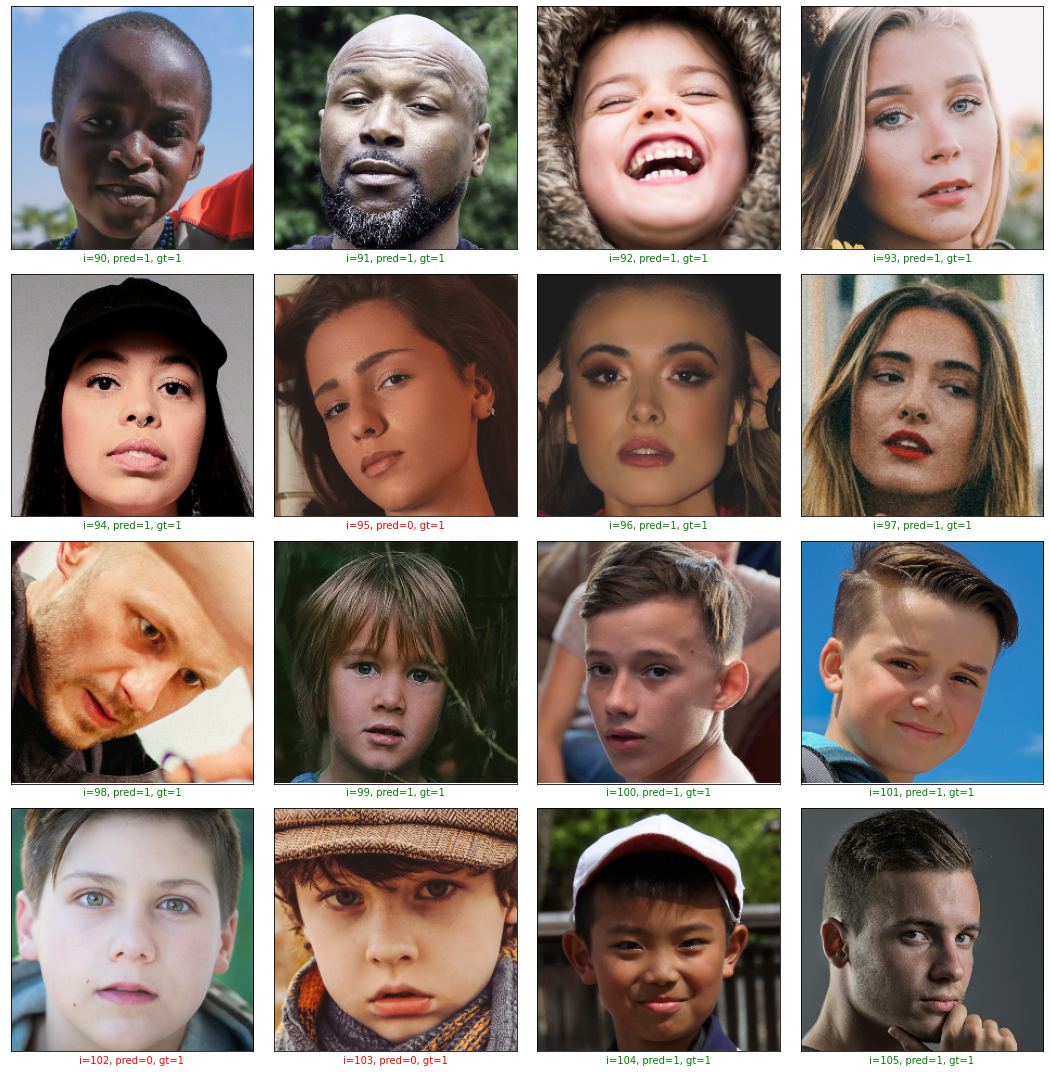

In [38]:
val_path = "realVSfake/real_and_fake_face/"

plt.figure(figsize=(15,15))

start_index = 90

for i in range(16):
    plt.subplot(4,4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    preds = np.argmax(predictions[[start_index+i]])
    
    gt = val.filenames[start_index+i][9:13]

  
    if gt == "fake":
        gt = 0
    else:
        gt = 1
    
    if preds != gt:
        col ="r"
    else:
        col = "g"

    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
    plt.imshow(load_img(val_path+val.filenames[start_index+i]))
    plt.tight_layout()

plt.show()

## Compiling our model which we saved using DeepC Compiler

In [42]:
!deepCC my_model.h5

reading [keras model] from 'vgg_model.h5'
Saved 'vgg_model.onnx'
reading onnx model from file  vgg_model.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_2's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  vgg_model_deepC/vgg_model.cpp
INFO (ONNX): model files are ready in dir vgg_model_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 vgg_model_deepC/vgg_model.cpp -o vgg_model_deepC/vgg_model.exe
Model executable  vgg_model_deepC/vgg_model.exe
